In [103]:
import networkx as nx
import random
import timeit
from dwave_qbsolv import QBSolv
import numpy as np

In [220]:
import numpy as np
import math


n = int(input("Enter number of nodes in network: "))

Enter number of nodes in network: 10


In [222]:
buf_size = (n-1)*50
p_arrival = 3/4

node_buf = np.zeros([n,n])
node_buf_without_transmit = np.zeros([n,n])    
node_buf
#np.random.randint(1,n-1)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [223]:
#Arrival step
def arrivals():
    for i in range(n):
        packet = np.random.randint(0,n)
       
        
        if(np.random.rand()<=p_arrival):
            if(packet!=i):
                node_buf[i,packet] += 1
                node_buf_without_transmit[i,packet] += 1
                

In [224]:
def transmissions(connections):
    if(len(connections)>0):
        for connection in connections:
            sender = int(connection[0]-1)
            receiver = int(connection[1]-1)
            
            if(node_buf[sender][receiver]<node_buf[receiver][sender]):
                temp = sender
                sender = receiver
                receiver = temp
            if(node_buf[sender,receiver]>0):
                node_buf[sender,receiver] -= 1

def get_keys(my_dict):
    connections_li = []
    for key, value in my_dict.items():
        if 1 == value:
            connections_li.append(key)
 
    return connections_li

def convert_to_network_connection(connections_list):
    output_connections = []
    for num in connections_list:
        for i in range(n):
            if(num<i*(i+1)/2):
                x_pos = i+1
                y_pos = num - (i*(i-1)/2)+1
                output_connections.append((x_pos,y_pos))
                break
    return output_connections

In [230]:
arrivals()

node_buf

array([[0., 0., 0., 0., 1., 3., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0., 1., 2.],
       [0., 1., 0., 0., 1., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 0., 1., 3., 0., 0., 0., 0., 0., 1.],
       [0., 0., 2., 0., 0., 0., 0., 0., 2., 0.],
       [0., 0., 1., 2., 0., 1., 0., 0., 0., 2.],
       [0., 0., 2., 1., 1., 0., 2., 0., 0., 0.],
       [0., 0., 2., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 2., 1., 0.]])

In [231]:
def form_QUBO(node_buf,conflict_set):
    num_nodes = n*(n-1)/2
    max_val = np.max(node_buf)

    Q = {}

    for i in range(n):
        for j in range(i):
            Q[((i*(i-1)/2)+j,(i*(i-1)/2)+j)] = -max(node_buf[i,j],node_buf[j,i])

            for k in range(i):
                if(j!=k):
                    Q[((i*(i-1)/2)+j,i*(i-1)/2+k)] = 2*max_val
                    
            for k in range(j):
                if(k!=i):
                    Q[(j*(j-1)/2+k,(i*(i-1)/2)+j)] = 2*max_val
                    
            for k in range(j+1,n):    
                if(i!=k):
                    Q[((k*(k-1)/2)+j,i*(i-1)/2+j)] = 2*max_val

            for k in range(i+1,n):
                Q[((k*(k-1)/2)+i,i*(i-1)/2+j)] = 2*max_val

            for k in conflict_set[i]:
                if(k!=i):
                    for l in range(k+1,n):
                        Q[((l*(l-1)/2)+k,i*(i-1)/2+j)] = 2*max_val
    #                     print((l*(l-1)/2)+k)

                    for l in range(k):
                        Q[((k*(k-1)/2)+l,i*(i-1)/2+j)] = 2*max_val
    #                     print((k*(k-1)/2)+l)
    return Q
    # print(Q)        

In [232]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
 
xMin=0
xMax=1
yMin=0
yMax=1
xDelta=xMax-xMin
yDelta=yMax-yMin
areaTotal=xDelta*yDelta;
 
# lambda0=10; #intensity (ie mean density) of the Poisson process
 
#Simulate Poisson point process
# numbPoints = scipy.stats.poisson( lambda0*areaTotal ).rvs()            #Poisson number of points

numbPoints = 10
xx = xDelta*scipy.stats.uniform.rvs(0,1,((numbPoints,1)))+xMin         #x coordinates of Poisson points
yy = yDelta*scipy.stats.uniform.rvs(0,1,((numbPoints,1)))+yMin         #y coordinates of Poisson points

# #Plotting
# plt.scatter(xx,yy, edgecolor='b', facecolor='none', alpha=0.5 )
# plt.xlabel("x"); plt.ylabel("y")

In [233]:
r = math.sqrt(areaTotal/math.pi)/10
conflict_set = []
for i in range(numbPoints):
    temp_list = []
    for j in range(numbPoints):
        if((xx[i]-xx[j])**2 + (yy[i]-yy[j])**2 < r**2):
            temp_list.append(j)
    conflict_set.append(temp_list)        

In [234]:
conflict_set

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]

In [235]:
for time in range(10):
    
    arrivals()
    Q = form_QUBO(node_buf,conflict_set)
#     print(Q)
    # start_time = timeit.default_timer()
    response = QBSolv().sample_qubo(Q)
    # end_time = timeit.default_timer()
    # time_taken = end_time - start_time

    # print("Time taken = " + str(time_taken))
    Energies = list(response.data_vectors['energy'])
    pos = Energies.index(min(Energies))
    Samples = list(response.samples())
    # print(Energies[pos])
    # print(Samples[pos])


    connections_list = get_keys(Samples[pos])
    final_connections = convert_to_network_connection(connections_list)

    print(node_buf)

    transmissions(final_connections)

    print("\n")
    print("\n")

    print(final_connections)

    print("\n")
    print("\n")

    print(node_buf)
    
    print("\n")
    print("\n")


/home/pranav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: QBSolv is deprecated as of the end of 2021 and support will be discontinued after March 2022. Please update your code to use dwave-hybrid or Leap's quantum-classical hybrid solvers instead.
  import sys


[[0. 0. 0. 0. 1. 3. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 1. 2.]
 [0. 1. 0. 0. 2. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 2. 0. 1. 0. 1. 0.]
 [0. 0. 1. 3. 0. 0. 0. 0. 0. 1.]
 [1. 0. 2. 0. 0. 0. 0. 0. 2. 0.]
 [0. 0. 1. 2. 0. 2. 0. 0. 0. 2.]
 [0. 0. 2. 1. 1. 0. 2. 0. 0. 0.]
 [0. 0. 3. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 2. 1. 0.]]




[(6, 1.0), (10, 2.0), (9, 3.0), (5, 4.0), (8, 7.0)]




[[0. 0. 0. 0. 1. 2. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 1. 1.]
 [0. 1. 0. 0. 2. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 2. 0. 1. 0. 1. 0.]
 [0. 0. 1. 2. 0. 0. 0. 0. 0. 1.]
 [1. 0. 2. 0. 0. 0. 0. 0. 2. 0.]
 [0. 0. 1. 2. 0. 2. 0. 0. 0. 2.]
 [0. 0. 2. 1. 1. 0. 1. 0. 0. 0.]
 [0. 0. 2. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 2. 1. 0.]]




[[0. 0. 0. 0. 1. 2. 0. 1. 0. 0.]
 [2. 0. 0. 1. 0. 0. 0. 0. 1. 1.]
 [0. 1. 0. 0. 2. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 2. 0. 1. 0. 1. 0.]
 [1. 0. 1. 2. 0. 0. 0. 0. 0. 1.]
 [1. 0. 2. 0. 0. 0. 1. 0. 2. 0.]
 [0. 0. 1. 2. 0. 2. 0. 0. 0. 2.]
 [0. 0. 3. 1. 1. 0. 1. 0. 0. 0.]
 [0. 0. 2.

In [236]:
node_buf_without_transmit - node_buf

array([[0., 0., 0., 0., 1., 2., 0., 1., 0., 1.],
       [2., 0., 0., 1., 0., 0., 1., 0., 2., 2.],
       [1., 1., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 2., 0., 0., 0., 0., 0.],
       [1., 0., 0., 3., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0., 2., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 2.],
       [0., 0., 2., 1., 1., 0., 3., 0., 0., 0.],
       [0., 0., 4., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 1., 0., 2., 0., 0.]])

Text(0, 0.5, 'y')

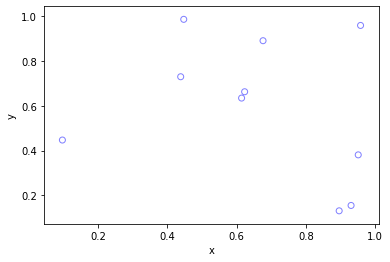

In [178]:
#Plotting
plt.scatter(xx,yy, edgecolor='b', facecolor='none', alpha=0.5 )
plt.xlabel("x"); plt.ylabel("y")